<a href="https://colab.research.google.com/github/G1useppe/ma5851_capstone_T0CE/blob/main/PROCESSING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setup

In [165]:
from google.colab import drive #mounting google drive to access webscraping output

import pandas as pd #general 
import numpy as np

import re #language processing
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

import matplotlib.pyplot as plt #visualization
import seaborn as sns 

from sklearn.feature_extraction.text import TfidfVectorizer #feature extraction
from sklearn.feature_extraction.text import CountVectorizer
import scipy.sparse

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [166]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


To begin the second part of our workflow, we will bring in the .xlsx file that we produced in our webscraping component.

In [167]:
path = '/content/drive/MyDrive/str_data.xlsx'
str_data = pd.read_excel(path, na_values = 'NaN')
str_data.head()

,Unnamed: 0,Company_City,Job Title,Salary,Description
0,0,Transurban\nDocklands VIC,Data Enablement Graduate,NaN,As one of the world's largest toll-road operat...
1,1,Suncorp Group\nBrisbane QLD,Suncorp 2023 Data Science Graduate Program,NaN,At Suncorp Group we work with care to create t...
2,2,UGL Limited\nNorth Shore NSW,Data Science Graduate/Undergraduate - Immed St...,NaN,Be part of the Award Winning CIMIC Graduate Pr...
3,3,Alfred Health\nMelbourne VIC,Graduate Research Laboratory Scientist,NaN,Alfred Health\n\nAlfred Health is a leader in ...
4,4,Deloitte\nCanberra ACT 2609,Consulting - Data & AI - 2022/23 Graduate Prog...,NaN,"Date: 16-Aug-2022\n\nLocation:\nCanberra, ACT,..."


# Data Wrangling

This data is really dirty and the subsequent code blocks will clean the raw data that we scraped from Indeed into meaningful data that we can pass to our machine learning model. The first task is to parse the combined Company_City field into three separate fields, Company, City and State.

Using the str.split method on with the "\n" string as a separator we can parse this string into more useful parts.

In [168]:
company_city = str_data['Company_City'].str.split(pat = "\n", expand = True)
company_city.head()

,0,1,2
0,Transurban,Docklands VIC,None
1,Suncorp Group,Brisbane QLD,None
2,UGL Limited,North Shore NSW,None
3,Alfred Health,Melbourne VIC,None
4,Deloitte,Canberra ACT 2609,None


We append the series to the data frame, and subsequently drop the components we no longer need.

In [169]:
str_data[["Company", "City", "Drop"]] = company_city
str_data.head()

,Unnamed: 0,Company_City,Job Title,Salary,Description,Company,City,Drop
0,0,Transurban\nDocklands VIC,Data Enablement Graduate,NaN,As one of the world's largest toll-road operat...,Transurban,Docklands VIC,None
1,1,Suncorp Group\nBrisbane QLD,Suncorp 2023 Data Science Graduate Program,NaN,At Suncorp Group we work with care to create t...,Suncorp Group,Brisbane QLD,None
2,2,UGL Limited\nNorth Shore NSW,Data Science Graduate/Undergraduate - Immed St...,NaN,Be part of the Award Winning CIMIC Graduate Pr...,UGL Limited,North Shore NSW,None
3,3,Alfred Health\nMelbourne VIC,Graduate Research Laboratory Scientist,NaN,Alfred Health\n\nAlfred Health is a leader in ...,Alfred Health,Melbourne VIC,None
4,4,Deloitte\nCanberra ACT 2609,Consulting - Data & AI - 2022/23 Graduate Prog...,NaN,"Date: 16-Aug-2022\n\nLocation:\nCanberra, ACT,...",Deloitte,Canberra ACT 2609,None


In [170]:
str_data = str_data.drop(['Unnamed: 0', 'Company_City', 'Drop'], axis = 1)
str_data.head()

,Job Title,Salary,Description,Company,City
0,Data Enablement Graduate,NaN,As one of the world's largest toll-road operat...,Transurban,Docklands VIC
1,Suncorp 2023 Data Science Graduate Program,NaN,At Suncorp Group we work with care to create t...,Suncorp Group,Brisbane QLD
2,Data Science Graduate/Undergraduate - Immed St...,NaN,Be part of the Award Winning CIMIC Graduate Pr...,UGL Limited,North Shore NSW
3,Graduate Research Laboratory Scientist,NaN,Alfred Health\n\nAlfred Health is a leader in ...,Alfred Health,Melbourne VIC
4,Consulting - Data & AI - 2022/23 Graduate Prog...,NaN,"Date: 16-Aug-2022\n\nLocation:\nCanberra, ACT,...",Deloitte,Canberra ACT 2609


To see the different kinds of cases we will need to clean for our new City variable, we can pass unique() through the column to get a glimpse of the different ways in which this field is entered. 

In [171]:
str_data.City.unique()

array(['Docklands VIC', 'Brisbane QLD', 'North Shore NSW',
       'Melbourne VIC', 'Canberra ACT 2609', 'Mulgrave VIC',
       'Parramatta NSW', 'Parkville VIC', 'Sydney NSW', 'Paddington NSW',
       'Canberra ACT', 'Australia', 'Port Melbourne VIC 3207',
       'Sydney NSW 2000', 'Victoria', 'Southbank VIC', 'Remote',
       'Belconnen ACT 2617', 'Perth WA', 'Melbourne City Centre VIC',
       'Crawley WA', 'City of Knox VIC', 'Queensland',
       'Melbourne VIC 3000', 'South Melbourne VIC 3205',
       'Adelaide CBD SA 5000', 'Geelong VIC', 'Newcastle NSW',
       'New South Wales', 'Alice Springs NT 0870', 'Alexandria NSW',
       'Frankston VIC', 'Cremorne VIC 3121', 'Waurn Ponds VIC',
       'Sunbury VIC', 'Braeside VIC', 'Long Pocket QLD', 'Edinburgh SA',
       'North Sydney NSW 2060', 'Abbotsford VIC', 'Perth WA 6000',
       'Elizabeth SA', 'Brooklyn VIC', 'Gold Coast QLD', 'Queanbeyan NSW',
       'Kew VIC 3101', 'Karratha WA', 'Wide Bay-Burnett QLD',
       'Barangaroo NSW'

The below code block presents the first of many helper functions written in this processing. The intention of drop_postcode() is to scan the end of the string for a potential postcode, and drop it if found.

In [172]:
def drop_postcode(string):
  if string[-4:].isdigit():
    return string[:-5]
  else:
    return string

print(drop_postcode('Canberra ACT 2609'))
print(drop_postcode('Melbourne VIC'))

Canberra ACT
Melbourne VIC


The next two helper functions, get_state() and get_city() help extract the state/territory value from the City field.

In [173]:
short_states = {'New South Wales' : 'NSW', 
                  'Victoria' : "VIC", 
                  'Queensland': "QLD",
                  'Australian Captial Territory': 'ACT',
                  'South Australia' : 'SA',
                  'Western Australia' : 'WA',
                  'Northern Territory' : 'NT',
                  'Tasmania' : 'TAS'}

In [174]:
def get_state(string):
  if string in short_states:
    return short_states.get(string)
  elif string in ['Australia', 'Remote']:
    return np.NaN
  else:
    return string[-3:].replace(" ", "")

def get_city(string):
  string = string.replace(" Central Business District", "")
  if string in ['Australia', 'Remote']:
    return string
  city = string[:-3]
  if city[-1] == " ":
    return city[:-1]
  else:
    return city

print(get_state('Adelaide SA'))
print(get_city('North Shore NSW'))

SA
North Shore


We can now apply our helper functions across our data frame and complete our first cleaning task.

In [175]:
str_data["City"] = str_data["City"].apply(drop_postcode)
str_data["State"] = str_data["City"].apply(get_state)
str_data["City"] = str_data["City"].apply(get_city)
str_data.head()

,Job Title,Salary,Description,Company,City,State
0,Data Enablement Graduate,NaN,As one of the world's largest toll-road operat...,Transurban,Docklands,VIC
1,Suncorp 2023 Data Science Graduate Program,NaN,At Suncorp Group we work with care to create t...,Suncorp Group,Brisbane,QLD
2,Data Science Graduate/Undergraduate - Immed St...,NaN,Be part of the Award Winning CIMIC Graduate Pr...,UGL Limited,North Shore,NSW
3,Graduate Research Laboratory Scientist,NaN,Alfred Health\n\nAlfred Health is a leader in ...,Alfred Health,Melbourne,VIC
4,Consulting - Data & AI - 2022/23 Graduate Prog...,NaN,"Date: 16-Aug-2022\n\nLocation:\nCanberra, ACT,...",Deloitte,Canberra,ACT


In [176]:
str_data.State.unique()

array(['VIC', 'QLD', 'NSW', 'ACT', nan, 'WA', 'SA', 'NT', 'TAS'],
      dtype=object)

# Feature extraction

## Salary

Now that we have wrangled and parsed our data into meaningful attributes, we now need to process our six attributes into features that our machine learning model can handle. The first of these we will tackle is the target variable, Salary. To avoid unecessary iterating, we will perform the relevant computations on only the record that have an attached salary.

In [177]:
salaried_data = str_data[str_data["Salary"].notnull()]
non_salaried_data = str_data[str_data["Salary"].isna()]
if len(salaried_data) + len(non_salaried_data) != len(str_data):
  print("Something went wrong")

The salary field contains two important pieces of information: the pay rate and the pay frequency. We can use the str.split() method again, this time using the string " a" as a separator, and append this series back onto our data frame.

In [178]:
rate_freq = salaried_data['Salary'].str.split(pat = " a", expand = True)
rate_freq.head()

,0,1
9,"$103,308",year
12,"$101,035 - $118,442",year
14,"$60,895 - $68,954",year
17,$46.20,n hour
24,"$72,751 - $80,545",year


In [179]:
salaried_data[["Pay Rate", "Pay Freq"]] = rate_freq

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


By calling unique() on the Pay Freq field, we can write a helper function to determine the different types of pay periods, and the necessary correction to convert them to a full time yearly salary.

In [180]:
salaried_data["Pay Freq"].unique()

array([' year', 'n hour', ' day', ' month'], dtype=object)

The corrections for daily pay reflect the statistics captured by the OECD (2022). It was determine that an average Australian worked 1714 per year between the years of 2017-2021. This figure was then divided by 7.6, the basis for which is the standards set out by the Fair Work Ombudsman (2022) for full-time employees.

In [181]:
def get_pay_periods(string):
  if string == ' year':
    return 1
  if string == 'n hour':
    return 1714
  if string == ' day':
    return 225.5
  if string == ' month':
    return 12

In [182]:
salaried_data["Pay Periods"] = salaried_data["Pay Freq"].apply(get_pay_periods)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


The pay rate that we derived from parsing the original Salary field often comes as a range, so the helper function get_pay_amount() checks if it is presented as a range, and if so finds the midpoint. It also returns the pay amount as a float. 

In [183]:
def get_pay_amount(string):
  string = string.replace('$', '')
  string = string.replace(',', '')
  if '-' in string:
    string = string.split(' - ')
    pay_range = [float(x) for x in string]
    return sum(pay_range)/len(pay_range)
  else:
    return float(string)
  
print(get_pay_amount('$101,035 - $118,442'))
print(get_pay_amount('$103,308'))


109738.5
103308.0


Multiplying the pay amount by the pay rate gives us a new standardized attribute, Salary FTE (Full Time Equivalent).

In [184]:
salaried_data["Salary FTE"] = salaried_data["Pay Rate"].apply(get_pay_amount) * salaried_data["Pay Periods"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


The next few code blocks reshape the data so we can combine our data frames and continue processing these variables for our ML model.

In [185]:
salaried_data = salaried_data.drop(['Pay Rate', 'Pay Freq', 'Pay Periods', 'Salary'], axis = 1)
salaried_data.head()

,Job Title,Description,Company,City,State,Salary FTE
9,Junior Data Scientist,"Permanent role, Parramatta location, hybrid wo...",Sydney Water,Parramatta,NSW,103308.0
12,Research Assistant/Officer (Data Science Biost...,3 year contract\nPart-time and full-time hours...,Murdoch Childrens Research Institute,Parkville,VIC,109738.5
14,Clinical Trial Assistant,"12-month Full Time\nAttractive Salary $ 60,895...",Murdoch Childrens Research Institute,Parkville,VIC,64924.5
17,Administrative Officer,Job no: 0056574\nLocation: Parkville\nRole typ...,University of Melbourne,Parkville,VIC,79186.8
24,2023 STEM Graduate (multiple roles) (VPSG3.1),Job Description\n\nLocation: Melbourne\n\nJob ...,Department of Transport,Melbourne,VIC,76648.0


In [186]:
prefer_column_order = ["Salary FTE", "City", "State", "Company", "Job Title", "Description"]
non_salaried_data = non_salaried_data.rename({"Salary" : "Salary FTE"}, axis = 1)

salaried_data = salaried_data.reindex(columns = prefer_column_order)
non_salaried_data = non_salaried_data.reindex(columns = prefer_column_order)

In [187]:
str_data = pd.concat([salaried_data, non_salaried_data])
str_data = str_data.reset_index(drop = True)

## City

In [188]:
state_capitals = ['Sydney', 'Melbourne', 'Brisbane', 'Adelaide', 'Darwin', 'Canberra', 'Perth', 'Hobart']
def is_capital(string):
  if string in state_capitals:
    return True
  else:
    return False


In [189]:
str_data["Capital"] = str_data["City"].apply(is_capital)


## State

In [190]:
str_data = pd.get_dummies(str_data, columns = ["State"])
str_data.head()

,Salary FTE,City,Company,Job Title,Description,Capital,State_ACT,State_NSW,State_NT,State_QLD,State_SA,State_TAS,State_VIC,State_WA
0,103308.0,Parramatta,Sydney Water,Junior Data Scientist,"Permanent role, Parramatta location, hybrid wo...",False,0,1,0,0,0,0,0,0
1,109738.5,Parkville,Murdoch Childrens Research Institute,Research Assistant/Officer (Data Science Biost...,3 year contract\nPart-time and full-time hours...,False,0,0,0,0,0,0,1,0
2,64924.5,Parkville,Murdoch Childrens Research Institute,Clinical Trial Assistant,"12-month Full Time\nAttractive Salary $ 60,895...",False,0,0,0,0,0,0,1,0
3,79186.8,Parkville,University of Melbourne,Administrative Officer,Job no: 0056574\nLocation: Parkville\nRole typ...,False,0,0,0,0,0,0,1,0
4,76648.0,Melbourne,Department of Transport,2023 STEM Graduate (multiple roles) (VPSG3.1),Job Description\n\nLocation: Melbourne\n\nJob ...,True,0,0,0,0,0,0,1,0


## NLP with Company, Job Title and Description

### Lemmatizing

In [191]:
possessives = re.compile("\'s") 
oddchars = re.compile(r"[^\w\s]") 
linebreak = re.compile("\\n")
stopwords = set(stopwords.words('english'))

def text_cleaner(text):
  text = text.lower()
  text = re.sub(possessives, ' ', text)
  text = re.sub(oddchars, ' ', text)
  text = re.sub(linebreak, ' ', text)
  return text

def tokenize_lemmatize(text):
  stem = WordNetLemmatizer()
  tokens = []
  for word in word_tokenize(text):
    if word not in stopwords:
      tokens.append(stem.lemmatize(word))
  return tokens

def rejoiner(text):
  lem_sentence = ""
  for word in text:
    lem_sentence += word
    lem_sentence += " "
  return lem_sentence

def lemmatizer(text):
  clean_text = text_cleaner(text)
  tok_lem_text = tokenize_lemmatize(clean_text)
  lem_text = rejoiner(tok_lem_text)
  return lem_text

In [192]:
str_data["Company"] = str_data["Company"].apply(lemmatizer)
str_data["Job Title"] = str_data["Job Title"].apply(lemmatizer)
str_data["Description"] = str_data["Description"].apply(lemmatizer)
str_data.head()

,Salary FTE,City,Company,Job Title,Description,Capital,State_ACT,State_NSW,State_NT,State_QLD,State_SA,State_TAS,State_VIC,State_WA
0,103308.0,Parramatta,sydney water,junior data scientist,permanent role parramatta location hybrid work...,False,0,1,0,0,0,0,0,0
1,109738.5,Parkville,murdoch childrens research institute,research assistant officer data science biosta...,3 year contract part time full time hour avail...,False,0,0,0,0,0,0,1,0
2,64924.5,Parkville,murdoch childrens research institute,clinical trial assistant,12 month full time attractive salary 60 895 68...,False,0,0,0,0,0,0,1,0
3,79186.8,Parkville,university melbourne,administrative officer,job 0056574 location parkville role type casua...,False,0,0,0,0,0,0,1,0
4,76648.0,Melbourne,department transport,2023 stem graduate multiple role vpsg3 1,job description location melbourne job type fu...,True,0,0,0,0,0,0,1,0


### Company Corpus Visualization

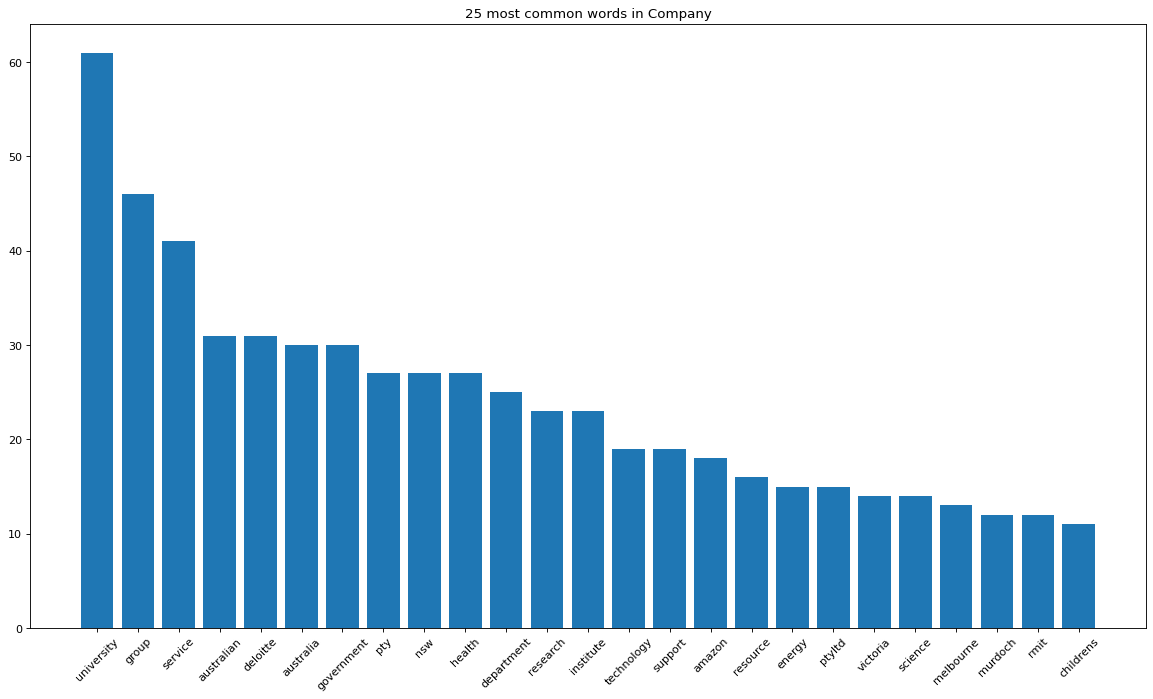

In [193]:
cv = CountVectorizer(ngram_range=(1, 1), stop_words='english')
cv_matrix = cv.fit_transform(str_data['Company'])
total_words = cv_matrix.sum(axis=0) 
freq = [(word, total_words[0, idx]) for word, idx in cv.vocabulary_.items()]
freq = sorted(freq, key = lambda x: x[1], reverse=True)
ngram = pd.DataFrame(freq)
ngram.rename(columns = {0: 'word', 1: 'count'}, inplace = True) 
ngram = ngram.head(25)
plt.figure(figsize=(18, 10), dpi=80)
plt.bar(ngram['word'], ngram['count'])
plt.xticks(rotation = 45)
plt.title(label = "25 most common words in Company")
plt.show()

### Company Feature Extraction

In [194]:
feature_extraction_company = CountVectorizer(max_features = 25, ngram_range = (1,1), stop_words = 'english')

In [195]:
feature_company_sparse = feature_extraction_company.fit_transform(str_data['Company'])
feature_company_df = pd.DataFrame.sparse.from_spmatrix(feature_company_sparse)

In [196]:
feature_names_company = list(feature_extraction_company.vocabulary_.keys())
feature_names_company = ['company_' + feature for feature in feature_names_company]
feature_company_df.columns = feature_names_company

### Job Title Corpus Visualization

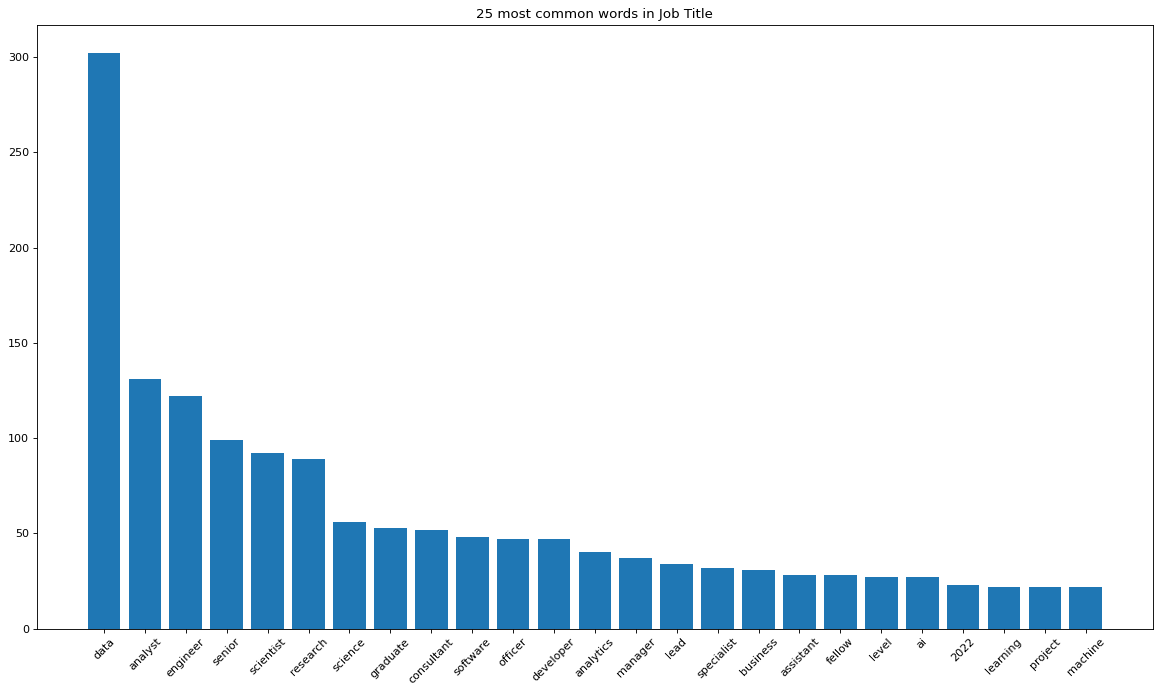

In [197]:
cv = CountVectorizer(ngram_range=(1, 1), stop_words='english')
cv_matrix = cv.fit_transform(str_data['Job Title'])
total_words = cv_matrix.sum(axis=0) 
freq = [(word, total_words[0, idx]) for word, idx in cv.vocabulary_.items()]
freq = sorted(freq, key = lambda x: x[1], reverse=True)
ngram = pd.DataFrame(freq)
ngram.rename(columns = {0: 'word', 1: 'count'}, inplace = True) 
ngram = ngram.head(25)
plt.figure(figsize=(18, 10), dpi=80)
plt.bar(ngram['word'], ngram['count'])
plt.xticks(rotation = 45)
plt.title(label = "25 most common words in Job Title")
plt.show()

### Job Title Feature Extraction

In [198]:
feature_extraction_title = CountVectorizer(max_features = 25, ngram_range = (1,1), stop_words = 'english')

In [199]:
feature_title_sparse = feature_extraction_title.fit_transform(str_data['Job Title'])
feature_title_df = pd.DataFrame.sparse.from_spmatrix(feature_title_sparse)

In [200]:
feature_names_title = list(feature_extraction_title.vocabulary_.keys())
feature_names_title = ['title_' + feature for feature in feature_names_title]
feature_title_df.columns = feature_names_title

### Description Corpus Visualization

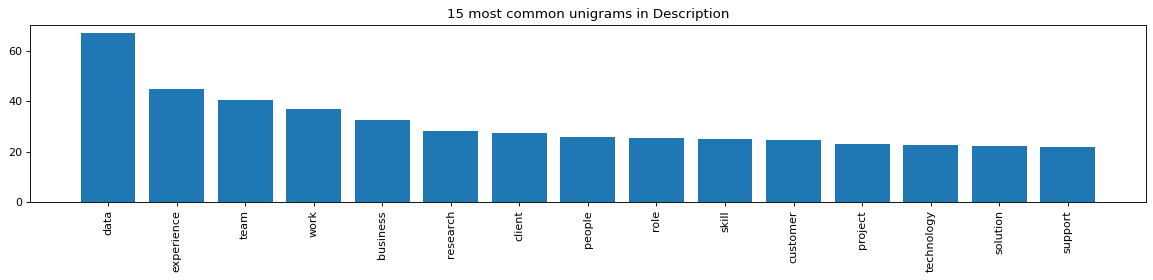

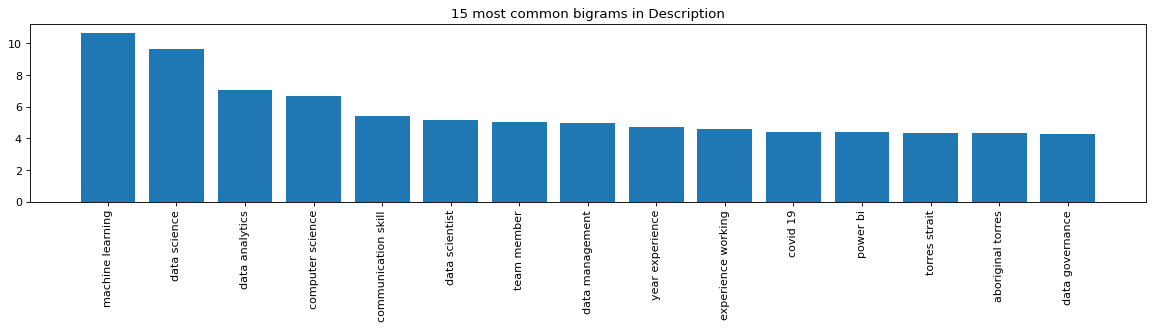

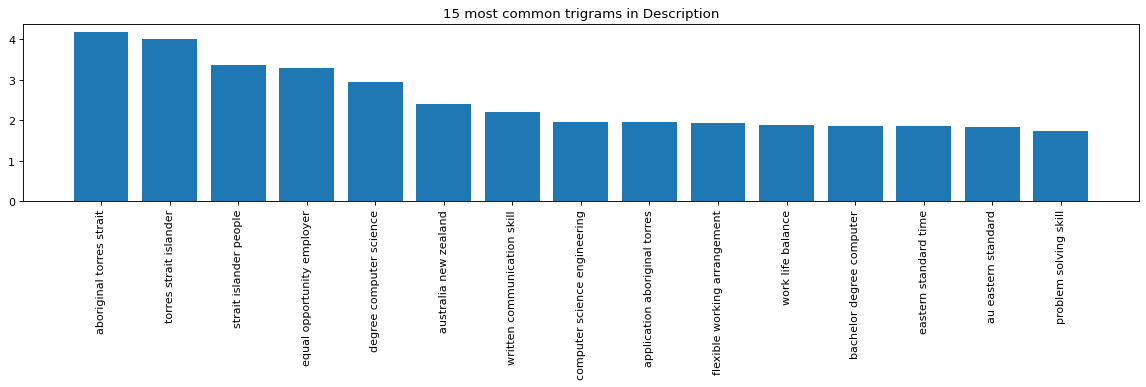

In [201]:
prefix_dict = {1:'Uni', 2:'Bi', 3:'Tri'}
for n in [1, 2, 3]:
  feature = prefix_dict.get(n) + 'gram'
  tf = TfidfVectorizer(ngram_range=(n, n), stop_words='english')
  tfidf_matrix = tf.fit_transform(str_data['Description'])
  total_words = tfidf_matrix.sum(axis=0) 
  freq = [(word, total_words[0, idx]) for word, idx in tf.vocabulary_.items()]
  freq = sorted(freq, key = lambda x: x[1], reverse=True)
  ngram = pd.DataFrame(freq)
  ngram.rename(columns = {0: feature, 1: 'count'}, inplace = True) 
  ngram = ngram.head(15)
  plt.figure(figsize=(18, 10), dpi=80)
  plt.subplot(310+n)
  plt.bar(ngram[feature], ngram['count'])
  plt.title(label = "15 most common " + feature.lower() + "s in Description")
  plt.xticks(rotation = 90)


### Description Feature Extraction

In [202]:
feature_extraction_description = TfidfVectorizer(max_df = 0.25, min_df = 0.01, ngram_range = (1,3), stop_words = 'english', max_features = 250)

In [203]:
feature_description_sparse = feature_extraction_description.fit_transform(str_data['Description'])
feature_description_df = pd.DataFrame.sparse.from_spmatrix(feature_description_sparse)

In [204]:
feature_names_description = list(feature_extraction_description.vocabulary_.keys())
feature_names_description = ['desc_' + feature for feature in feature_names_description]
feature_description_df.columns = feature_names_description

### Data Frame Concatenation

In [209]:
feature_data = pd.concat([str_data, feature_company_df, feature_title_df, feature_description_df], axis = 1)
feature_data = feature_data.drop(['City', 'Company', 'Job Title', 'Description'], axis = 1)
feature_data.head()

,Salary FTE,Capital,State_ACT,State_NSW,State_NT,State_QLD,State_SA,State_TAS,State_VIC,State_WA,...,desc_helping,desc_pipeline,desc_data management,desc_user,desc_insurance,desc_bachelor degree,desc_aws,desc_marketing,desc_energy,desc_sale
0,103308.0,False,0,1,0,0,0,0,0,0,...,0.0596,0.000000,0.000000,0.000000,0.054629,0.0,0.0,0.0,0.000000,0.0
1,109738.5,False,0,0,0,0,0,0,1,0,...,0.0000,0.000000,0.091901,0.071474,0.000000,0.0,0.0,0.0,0.000000,0.0
2,64924.5,False,0,0,0,0,0,0,1,0,...,0.0000,0.076432,0.000000,0.075535,0.000000,0.0,0.0,0.0,0.000000,0.0
3,79186.8,False,0,0,0,0,0,0,1,0,...,0.0000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.079768,0.0
4,76648.0,True,0,0,0,0,0,0,1,0,...,0.0000,0.000000,0.457190,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0


# Output

In [211]:
feature_data.to_excel('feature_data.xlsx')
!cp feature_data.xlsx "drive/My Drive/"

# References

https://stats.oecd.org/index.aspx?DataSetCode=ANHRS

https://www.fairwork.gov.au/starting-employment/types-of-employees/full-time-employees